## Burger's equation modelling with Phiflow

In [2]:
%reset -f
from phi.flow import *      ## Phiflow version 2.2.5
from phi import __version__
print("Using phiflow version: {} ".format(phi.__version__))

Using phiflow version: 2.2.5 


In [3]:
N = 128
DX = 2./N
STEPS = 32
DT = 1./STEPS
NU = 0.01/(N*np.pi)
# initialization of velocities, cell centers of a CenteredGrid have DX/2 offsets for linspace()
# INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D
INITIAL_NUMPY = -np.sin(np.pi * np.linspace(-1+DX/2,1-DX/2,N)) # 1D

INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

In [4]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box['x', -1:1])
# vt = advect.semi_lagrangian(velocity, velocity, DT)
velocity = CenteredGrid(lambda x: -math.sin(np.pi * x), extrapolation.PERIODIC, x=N, bounds=Box['x', -1:1])
# velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box['x', -1:1]) # random init

print("Velocity tensor shape: " + format( velocity.shape )) # == velocity.values.shape
print("Velocity tensor type: " + format( type(velocity.values) ))
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy('x')[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phi.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.49289817 0.5349975  0.5758082  0.6152315  0.65317285]


In [5]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)
print("New velocity content at t={} : {} ".format( age, velocities[-1].values.numpy('x,vector')[0:5] ))

New velocity content at t=1.0 : [[0.00572288]
 [0.01716723]
 [0.02861037]
 [0.04005202]
 [0.05149215]] 


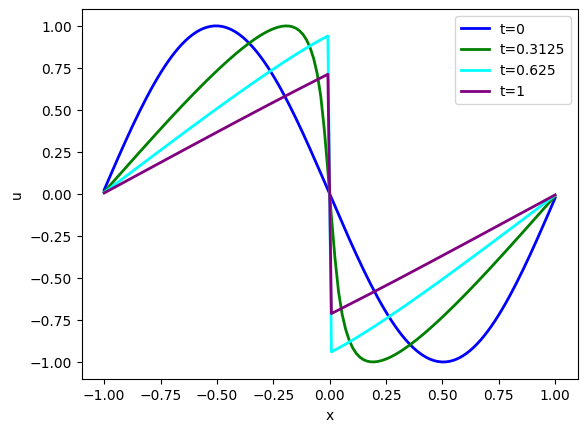

In [6]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector"
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays

import pylab
fig = pylab.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue', label="t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label="t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan', label="t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

Resulting image size(128, 528)


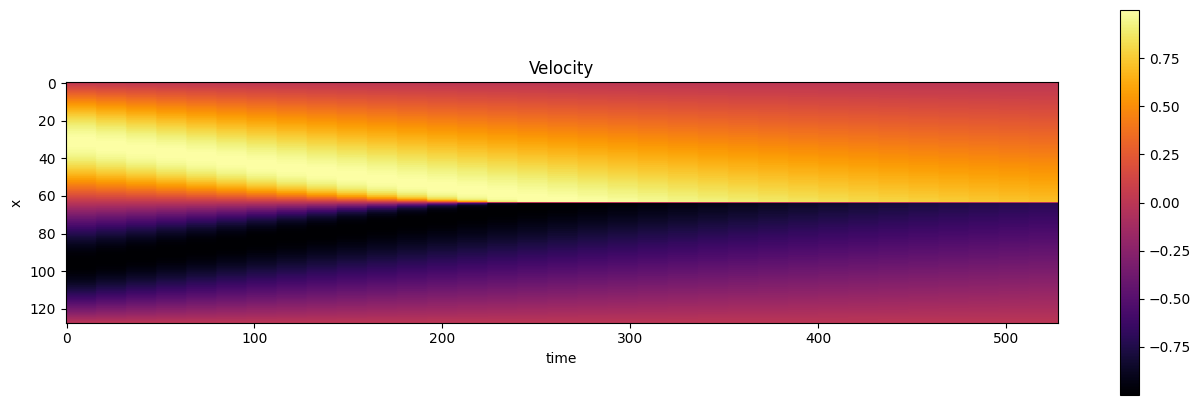

In [7]:
def show_state(a, title):
    # we only have 33 time steps, blow up by a factor of 2^4=16 to make it easier to see
    # (could also be done with more evaluations of network)
    a = np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    print("Resulting image size" +format(a.shape))

    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)

vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )

# save for comparison with reconstructions later on
import os; os.makedirs("./temp", exist_ok=True)
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1])) #remove batch & channel dimension

show_state(vels_img, "Velocity")

## Navier-Stokes's equation modelling with Phiflow

In [13]:
DT = 1.5
NU = 0.01
INFLOW = CenteredGrid(Sphere(x=30, y=15, radius=10), extrapolation.BOUNDARY, x=32, y=40, bounds=Box['x,y', 0:80, 0:100]) * 0.2

In [16]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box['x,y', 0:80, 0:100]) # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box['x,y', 0:80, 0:100]) # sampled in staggered form at face centers

Max. velocity and mean marker density: [0.1558497, 0.008125]


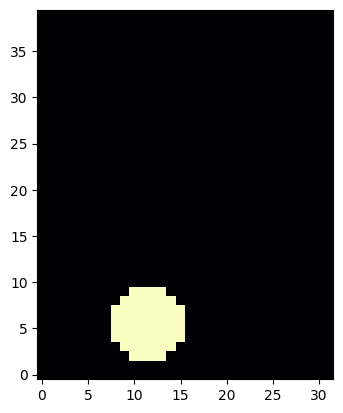

In [17]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW

    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity) # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)

    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values), math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma')

In [18]:
print(f"Smoke: { smoke.shape} ")
print(f"Velocity: { velocity.shape} ")
print(f"Inflow: { INFLOW.shape} , spatial only: { INFLOW.shape.spatial} ")

Smoke: (xˢ=32, yˢ=40) 
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y) 
Inflow: (xˢ=32, yˢ=40) , spatial only: (xˢ=32, yˢ=40) 


In [19]:
print(f"Shape content: { velocity.shape.sizes} ")
print(f"Vector dimension: { velocity.shape.get_size('vector')} ")

Shape content: (32, 40, 2) 
Vector dimension: 2 


In [22]:
print("Statistics of the different simulation grids:")
print(smoke.values)
print(velocity.values)
# in contrast to a simple tensor:
test_tensor = math.tensor(numpy.zeros([2, 5, 3]), spatial('x,y'), channel('vector'))
print("Reordered test tensor shape: " + format(test_tensor.numpy('vector,y,x').shape) )
# print(test_tensor.values.numpy('y,x')) # error! tensors don't return their content via ".values"

Statistics of the different simulation grids:
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(xˢ=(x=31, y=32), yˢ=(x=40, y=39), vectorᶜ=x,y) -7.23e-09 ± 5.3e-03 (-1e-01...2e-01)
Reordered test tensor shape: (3, 5, 2)


In [23]:
for time_step in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {} , max velocity {} '.format(time_step , np.asarray(math.max(velocity.values)) ))

c:\Users\rouss\miniconda3\envs\jaxenv\lib\site-packages\IPython\core\interactiveshell.py:3433: SyntaxWarning: Automatic conversion of Φ-Flow tensors to NumPy can cause problems because the dimension order is not guaranteed.
  exec(code_obj, self.user_global_ns, self.user_ns)


Computed frame 0 , max velocity 0.463001012802124 
Computed frame 1 , max velocity 0.8966460227966309 
Computed frame 2 , max velocity 1.4098883867263794 
Computed frame 3 , max velocity 2.0411276817321777 
Computed frame 4 , max velocity 2.9279580116271973 
Computed frame 5 , max velocity 3.8394765853881836 
Computed frame 6 , max velocity 4.526946067810059 
Computed frame 7 , max velocity 4.867981910705566 
Computed frame 8 , max velocity 5.131080150604248 
Computed frame 9 , max velocity 5.4838786125183105 


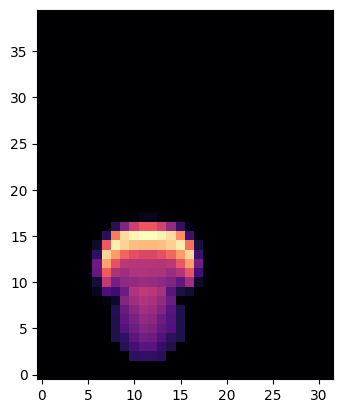

In [24]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

Computing time step 0 
Computing time step 1 
Computing time step 2 
Computing time step 10 
Computing time step 20 
Computing time step 30 
Computing time step 40 
Computing time step 50 


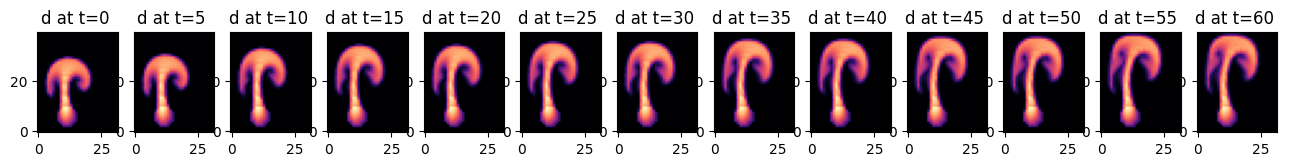

In [27]:
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
for time_step in range(60):
    if time_step<3 or time_step%10==0:
        print('Computing time step %d ' % time_step)
        velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    if time_step%5==0:
        steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={ i*5} ")

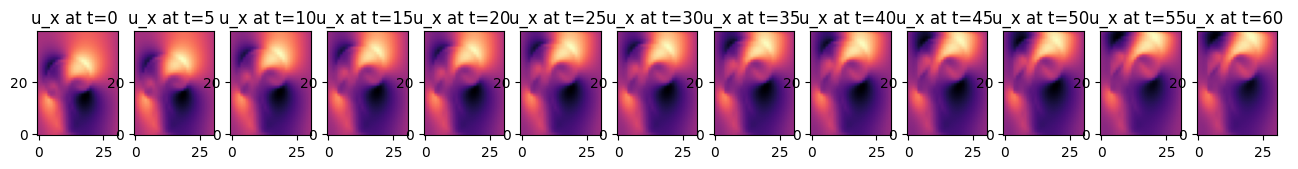

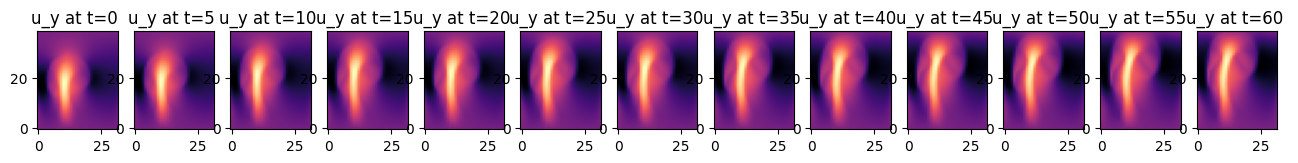

In [28]:
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_x at t={ i*5} ")

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_y at t={ i*5} ")